In [7]:
import pandas as pd
import transformers 
import numpy as np
import torch
import datasets

from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import sys

sys.path.insert(0, '..')

from decompose_gpt2 import GPT2ForSequenceClassificationDecomposed, GPT2Config
from build_masks import build_masks


### Load Model

In [2]:
labels = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

path = "../../combined_SPRL_gpt2"
model = transformers.AutoModelForSequenceClassification.from_pretrained(path)

new_state_dict = OrderedDict()
for key, value in model.state_dict().items():
    # ref : https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
    new_key = key.replace("ln_1.weight", "ln_1.gamma").replace("ln_1.bias", "ln_1.beta")
    new_key = new_key.replace("ln_2.weight", "ln_2.gamma").replace("ln_2.bias", "ln_2.beta")
    new_key = new_key.replace("ln_f.weight", "ln_f.gamma").replace("ln_f.bias", "ln_f.beta")
    new_state_dict[new_key] = value


In [3]:
decomposed_model = GPT2ForSequenceClassificationDecomposed(
    config= GPT2Config.from_dict(model.config.to_dict()),
    debug=False, 
    num_labels=len(labels) * 3
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(path + "/tokenizer")
decomposed_model.model.load_state_dict(new_state_dict)
decomposed_model.model.eval()


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x Block(
        (ln_1): LayerNorm((1024,), eps=1e-05)
        (attn): Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05)
        (mlp): MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05)
  )
  (score): Linear(in_features=1024, out_features=30, bias=False)
)

In [4]:
model = decomposed_model.model


### Load Data

In [5]:
roles_wide = pd.read_csv("../../../dataV2/combined_V1_V2.csv", na_filter=False)
roles_wide.drop("Unnamed: 0", inplace=True, axis=1)

roles_wide.rename({"Sentence": "sentence", "Arg.Phrase": "arg"}, axis=1, inplace=True)

properties_list = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

print(roles_wide.shape)
roles_wide["combined_labels"] = roles_wide["combined_labels"].apply(lambda x: eval(x))
roles_wide.head()


(28810, 14)


,Sentence.ID,Gram.Func,sentence,Predicate,Split,arg,Arg.Stripped,arg_idx,verb_idx,structure,decomp_version,Pred.Lemma,modified_sentence,combined_labels
0,0003_21,nsubj,"In July , a gradual ban was imposed by the Env...",was imposed by,test,a gradual ban,a ban,"(3, 6)","(6, 9)",passive_full,V1,impose,1,"[1.0, 1.0, 3.0, 1.0, 5.0, 1.0, 5.0, 1.0, 1.0, ..."
1,0003_21,dobj,"In July , a gradual ban was imposed by the Env...",was imposed by,train,the Environmental Protection Agency,the Environmental Protection Agency,"(9, 13)","(6, 9)",passive_full,V1,impose,1,"[5.0, 1.0, 3.0, 1.0, 5.0, 5.0, 5.0, 5.0, 1.0, ..."
2,0003_29,nsubj,No bearing on our work force today is had by it .,is had by,train,No bearing on our work force today,no bearing,"(0, 7)","(7, 10)",passive_full,V1,have,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0003_29,dobj,No bearing on our work force today is had by it .,is had by,test,it,It,"(10, 11)","(7, 10)",passive_full,V1,have,1,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 3.0, 2.0, ..."
4,0003_9,nsubj,A team of researchers from the National Cancer...,was led by,train,A team of researchers from the National Cancer...,a team,"(0, 19)","(19, 22)",passive_full,V1,lead,1,"[5.0, 3.0, 3.0, 1.0, 3.0, 3.0, 5.0, 3.0, 1.0, ..."


In [10]:
eval_df = roles_wide.loc[
    (roles_wide["decomp_version"] == "V2") & \
    (roles_wide["Split"] == "test")
    # (roles_wide["modified_sentence"] == 0)
    ][["Pred.Lemma", "Gram.Func", "structure", "sentence", "Predicate", "arg_idx", "verb_idx", "arg", "Arg.Stripped"]].drop_duplicates().reset_index()

print(eval_df.shape)
eval_df.head()


(639, 10)


,index,Pred.Lemma,Gram.Func,structure,sentence,Predicate,arg_idx,verb_idx,arg,Arg.Stripped
0,14299,raise,nsubj,active_full,A girl raises her hand .,raises,"(0, 2)","(2, 3)",A girl,A girl
1,14301,raise,dobj,active_full,A girl raises her hand .,raises,"(3, 5)","(2, 3)",her hand,the hand
2,14303,be,nsubj,active_full,""" I 'm afraid not , "" explains Winston , "" tha...",is,"(11, 12)","(12, 13)",that,that
3,14305,say,nsubj,active_full,"In a timid voice , he says : "" If an airplane ...",says,"(5, 6)","(6, 7)",he,he
4,14307,beam,nsubj,active_full,""" Wonderful ! "" Winston beams .",beams,"(4, 5)","(5, 6)",Winston,Winston


### Make Contribution Masks and Process Sentences

In [11]:
dataset, eval_df, lengths = build_masks(eval_df, tokenizer).values()

print(max(lengths))
eval_df.head()



arg:  her hand
stripped arg:  the hand
arg reconstructed (no mod):  her hand
mod reconstructed:  her

arg:  Our plans
stripped arg:  the plans
arg reconstructed (no mod):  Our plans
mod reconstructed:  Our

arg:  Walter Kistler, LTS co-founder and Chairman
stripped arg:  Kistler
arg reconstructed (no mod):  Walter Kistler, LTS co-founder and Chairman
mod reconstructed:  Walter LTS co-founder and Chairman

arg:  the letter, signed by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega
stripped arg:  the letter signed
arg reconstructed (no mod):  the letter, signed by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega
mod reconstructed:  by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega

arg:  The Sunni AMS
stripped arg:  The AMS
arg reconstructed (no mod):  The Sunni AMS
mod reconstructed:  Sunni

arg:  the right idea
stripped arg:  the idea
arg reconstructed

,index,sentence,structure,gram,contribution,mask
0,14299,<a>A girl<a><p> raises<p> her hand.,active_full,nsubj,arg_nomod_mask,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]"
1,14301,A girl<p> raises<p><a> her hand<a>.,active_full,dobj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


In [ ]:
max_length = 128

def tokenize_and_mask(t):
    encoded = tokenizer(t["sentence"], padding="max_length", truncation=True,
                        max_length=max_length, return_tensors="pt")
    
    beta_mask = np.pad(t["mask"], (0, max_length - len(t["mask"])%max_length), 'constant')
    beta_mask = torch.Tensor(beta_mask).to(int).unsqueeze(0)

    # replace the masked tokens with tokenizer.unk_token ('<|endoftext|>')
    mask_fill = tokenizer.unk_token_id
    encoded["input_ids_masked"] = encoded["input_ids"] * (1 - beta_mask) + mask_fill * beta_mask
    return encoded

test_set = datasets.Dataset.from_pandas(eval_df)
test_set = test_set.map(tokenize_and_mask)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/1917 [00:00<?, ? examples/s]

In [ ]:
# gen = test_set.iter(batch_size=4)
# with torch.no_grad():
#     for i, batch in enumerate(gen):
#         attention_mask = torch.Tensor(batch["attention_mask"]).to(torch.long).squeeze(1)
#         input_ids = torch.Tensor(batch["input_ids_masked"]).to(torch.long).squeeze(1)

#         l = model(input_ids=input_ids, attention_mask=attention_mask)["logits"].numpy()
#         np.save(f"mask_logits_gpt2/batch_{i}_logits.npy", l)
#         if i % 10 == 0:
#             print(i)


### Analyze Contributions

In [ ]:
logits = []
for i in range(480):
    a = np.load(f"mask_logits_gpt2/batch_{i}_logits.npy")
    logits.append(a)

logits = np.concatenate(logits, axis=0).reshape(-1, 3, 10)
logits.shape


(1917, 3, 10)

In [ ]:
logits_full = []
for i in range(480):
    a = np.load(f"gcd_logits_gpt2/batch_{i}_logits.npy").sum(0)
    logits_full.append(a)

logits_full = np.concatenate(logits_full, axis=0).reshape(-1, 3, 10)
logits_full.shape


(1917, 3, 10)

In [ ]:
logits_beta = logits_full - logits

eval_df["beta_contribution"] = (logits_beta / logits_full).tolist()
eval_df["span_length"] = eval_df["mask"].apply(lambda x: x.astype(int).sum()).replace(0, np.nan)
eval_df.dropna(subset="span_length", inplace=True)
eval_df["beta_contribution"] = eval_df.apply(
    lambda x: np.array(x["beta_contribution"])/(np.array(x["mask"]).astype(int).sum()),
    axis=1
)

eval_df.head()   


,index,sentence,structure,gram,contribution,mask,beta_contribution,span_length
0,14299,<a>A girl<a><p> raises<p> her hand.,active_full,nsubj,arg_nomod_mask,"[False, True, True, False, False, False, False...","[[0.45780591648975594, 0.5563146150426589, 0.1...",2.0
1,14301,A girl<p> raises<p><a> her hand<a>.,active_full,dobj,arg_nomod_mask,"[False, False, False, False, False, False, Fal...","[[1.5568798571280362, 0.2937931370093559, -1.1...",1.0
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",active_full,nsubj,arg_nomod_mask,"[False, False, False, False, False, False, Fal...","[[0.29922869553758374, 0.5287118901896459, 0.2...",1.0
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",active_full,nsubj,arg_nomod_mask,"[False, False, False, False, False, False, Tru...","[[0.5396214108757551, 1.5319847666947488, 2.15...",1.0
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",active_full,nsubj,arg_nomod_mask,"[False, False, False, False, False, True, Fals...","[[1.273747264630322, 0.6186737025611315, 0.785...",1.0


In [35]:
contributions_df = eval_df[["index", "sentence", "structure", "gram", "contribution", "beta_contribution"]]
contributions_df[labels] = contributions_df['beta_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

contributions_df = contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure"], value_vars=labels, value_name="logits",
    var_name="property")
contributions_df[["negative", "neutral", "positive"]] = contributions_df['logits'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

spans = {
    "arg_nomod": "argument",
    "arg_mod": "modifier",
    "pred": "predicate"
}
contributions_df["span"] = contributions_df["contribution"].apply(
    lambda x: spans["_".join(x.split("_")[:-1])])
contributions_df = contributions_df.melt(id_vars=[ "index", "sentence","span", "property", "gram", "structure"],
                      value_vars=["negative", "neutral", "positive"],
                      var_name="class", value_name="per_token_contribution")


/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_12077/950205662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contributions_df[labels] = contributions_df['beta_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))


In [ ]:
lower, upper = np.nanpercentile(contributions_df["per_token_contribution"].dropna().to_numpy(), [5, 95])
print(f"clipping outliers less than {lower} or greater than {upper}")
contributions_df["per_token_contribution_"] = contributions_df["per_token_contribution"].apply(
    lambda x: np.clip(x, a_min=0, a_max=upper)
)
contributions_df["structure"] = contributions_df["structure"].apply(
    lambda x: "_".join(x.split("_")[:-1]))
contributions_df.head()


clipping outliers less than -0.5935958790836356 or greater than 1.1417078431317573


,index,sentence,span,property,gram,structure,class,per_token_contribution,per_token_contribution_
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,negative,0.457806,0.457806
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,negative,1.556880,1.141708
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,negative,0.299229,0.299229
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,negative,0.539621,0.539621
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,negative,1.273747,1.141708


<Axes: xlabel='per_token_contribution', ylabel='Density'>

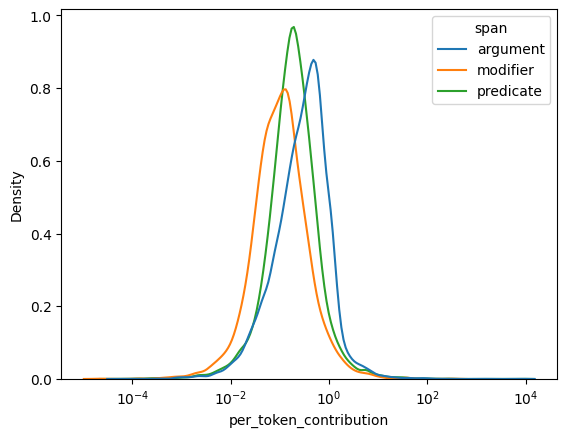

In [ ]:
sns.kdeplot(contributions_df, x="per_token_contribution", 
            hue="span", log_scale=True, common_norm=False)


In [ ]:
percentiles_df = []
n = 20

for span in ["argument", "modifier", "predicate"]:
    for p in np.arange(n + 1) * (100/n):
        x = np.nanpercentile(
        contributions_df.loc[contributions_df["span"] == span]["per_token_contribution"].to_numpy(),
        [p])[0]

        percentiles_df.append({
            "span": span,
            "percentile": p,
            "stat": x
        })

percentiles_df = pd.DataFrame(percentiles_df).pivot(index="percentile", values="stat", columns="span")
percentiles_df


span,argument,modifier,predicate
percentile,,,
0.0,-1085.969654,-458.202987,-760.714767
5.0,-0.654124,-0.403109,-0.619228
10.0,-0.196924,-0.143078,-0.231460
15.0,-0.052171,-0.053229,-0.095551
20.0,0.010310,-0.012252,-0.026215
25.0,0.039929,0.010231,0.015079
30.0,0.070772,0.023233,0.043599
35.0,0.102822,0.033384,0.065745
40.0,0.139220,0.043722,0.086176


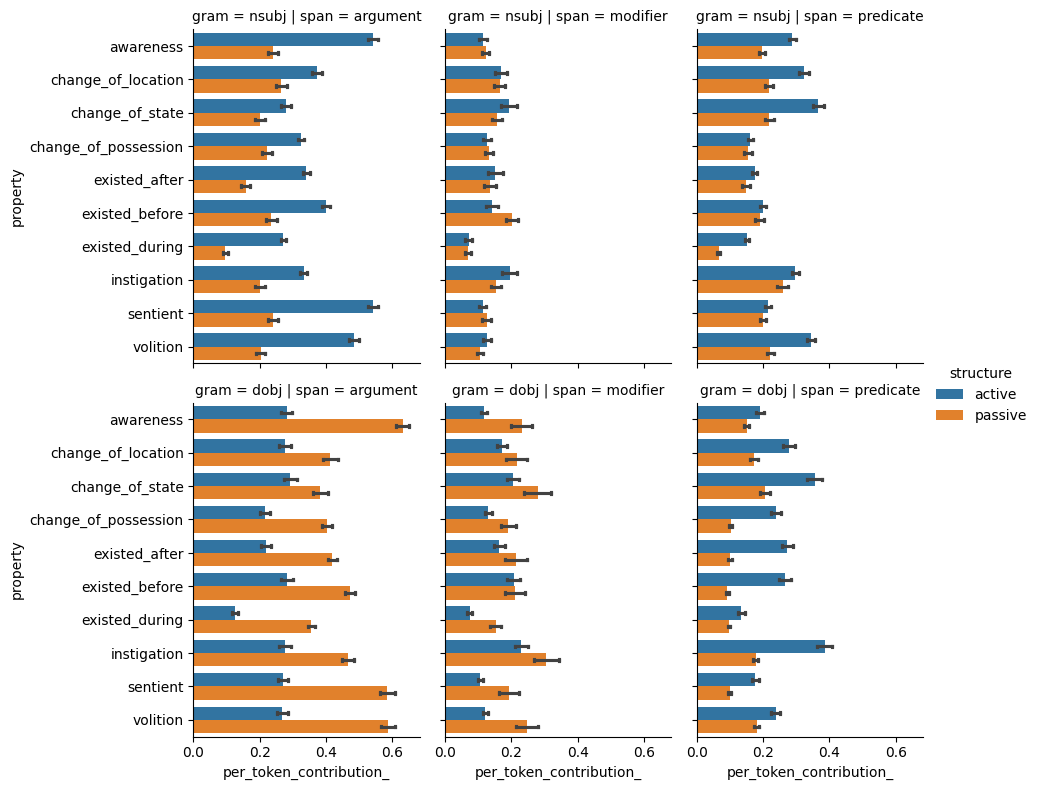

In [39]:
sns.catplot(
    contributions_df.loc[contributions_df["gram"] != "iobj"], col="span", kind="bar", hue="structure", orient="h", row="gram", 
    y = "property", x = "per_token_contribution_", errorbar="se", height=4, capsize=0.1,
    aspect=0.8)


/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_57863/2371734641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df["class"] = c_df["class"].replace("negative", "negative (1-2)"


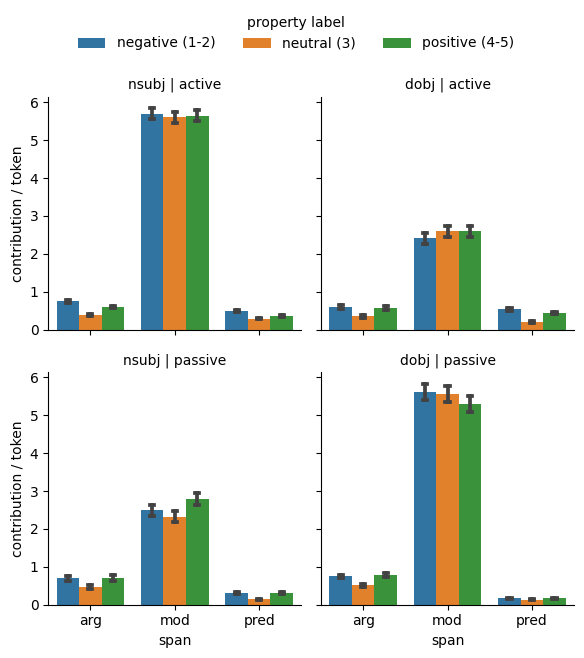

In [53]:
c_df = contributions_df.loc[contributions_df["gram"] != "iobj"]
c_df["class"] = c_df["class"].replace("negative", "negative (1-2)"
                                      ).replace("neutral", "neutral (3)"
                                                ).replace("positive", "positive (4-5)")

ax = sns.catplot(
    c_df, kind="bar", row = "structure", col="gram",
    x = "span", y = "per_token_contribution", hue="class", errorbar="se", capsize=0.05, height=3,
    sharey=True)
ax.set_titles("{col_name} | {row_name}")
ax.set_xticklabels(["arg", "mod", "pred"])
ax.set_axis_labels("span", "contribution / token")

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.42, 1), ncol=3,
                title="property label", frameon=False)
